In [11]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [12]:
abbreviations = {'EIN':'I', 'HE':'E', 'SAD':'A', 'SIN':'S', 'TA':'X', 'ZH':'W', 'TH':'G', 'SH':'U'}

characters = {'0': 0,'1': 1,'2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,
              'B': 10,'D': 11,'EIN': 12,'H': 13,'HE': 14,'J': 15, 'L':16, 'M':17, 'N': 18,
             'P': 19,'Q': 20,'SAD': 21,'SIN': 22,'T': 23,'TA': 24,'V': 25,'Y': 26, 'Z': 27,
             'SH': 28, 'TH':29, 'ZH': 30, 'A': 31, ' ': 32}

en_fa = {'0': 0,'1': 1,'2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,
         'ز': 'Z','ش': 'SH','ط': 'TA','پ': 'P','ث': 'TH','ژ (معلولین و جانبازان)': 'ZH',
         'الف': 'A','ع': 'EIN','ه‍': 'H','ق': 'Q','ت': 'T','م': 'M','ل': 'L','د': 'D',
         'ی': 'Y','ب': 'B', 'ج': 'J', 'ن': 'N'}

indexes = {'0': 0,'1': 1,'2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,
          'B': 10,'D': 11,'I': 12,'H': 13,'E': 14,'J': 15, 'L':16, 'M':17, 'N': 18,
         'P': 19,'Q': 20,'A': 21,'S': 22,'T': 23,'X': 24,'V': 25,'Y': 26, 'Z': 27,
          'U': 28,'G': 29,'W': 30,'A': 31,' ': 32}

rev_indexes_out = {'0': 0,'1': 1,'2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,
               'B': 'ب','D': 'د','I': 'ع','H': 'ه','E': 'ح','J': 'ج', 'L':'ل', 'M':'م', 'N': 'ن',
               'P': 'پ','Q': 'ق','A': 'الف','S': 'س','T': 'ت','X': 'ط','V': 'و','Y': 'ی', 'Z': 'ز',
               'U': 'ش','G': 'ث','W': 'ژ','A': 'الف',' ': 32}

rev_indexes = {v: k for k, v in indexes.items()}
n_classes = len(indexes) + 1


0: 448x640 1 Plate, 63.6ms
Speed: 3.5ms preprocess, 63.6ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


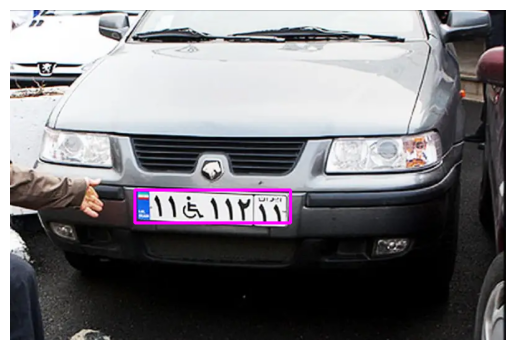

In [14]:
object_detection_weight = os.path.join("YoloModel/best.pt")

test_image = os.path.join("test_image_1.jpg")
test_image = cv.cvtColor(cv.imread(test_image), cv.COLOR_BGR2RGB)
img = test_image.copy()

object_detection_model = YOLO(object_detection_weight)
pred = object_detection_model(test_image)

for result in pred:
    boxes = result.boxes
    pred_img = result.orig_img
x_min, y_min = (int(boxes.xyxy[0][0]), int(boxes.xyxy[0][1]))
x_max, y_max = (int(boxes.xyxy[0][2]), int(boxes.xyxy[0][3]))

img = cv.rectangle(img, (x_max, y_max), (x_min, y_min), (255,0,255), 3)
plt.imshow(img)
plt.axis('off')
plt.show()

# Post proccess the image to increase image resolution

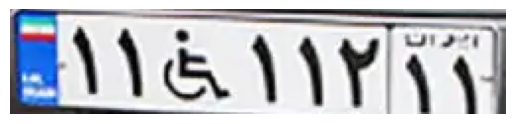

In [16]:
plate = test_image[y_min:y_max, x_min:x_max, :]
plt.imshow(plate)
plt.axis('off')
plt.show()

In [17]:
def enhance_color_image(image_pil):
    img = np.array(image_pil)
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)

    denoised = cv.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv.filter2D(denoised, -1, kernel)

    lab = cv.cvtColor(sharpened, cv.COLOR_BGR2LAB)
    l, a, b = cv.split(lab)

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    a = cv.normalize(a, None, alpha=120, beta=135, norm_type=cv.NORM_MINMAX)
    b = cv.normalize(b, None, alpha=120, beta=135, norm_type=cv.NORM_MINMAX)

    enhanced_lab = cv.merge((cl, a, b))
    enhanced_bgr = cv.cvtColor(enhanced_lab, cv.COLOR_LAB2BGR)

    enhanced_rgb = cv.cvtColor(enhanced_bgr, cv.COLOR_BGR2RGB)
    final_image = Image.fromarray(enhanced_rgb)
    return final_image

plate = enhance_color_image(plate)

In [18]:
class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh, dropout_prob=0.3):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_prob),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_prob),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Dropout(dropout_prob),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Dropout(dropout_prob),
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU(True)
        )

        self.rnn1 = nn.LSTM(512, nh, bidirectional=True)
        self.rnn2 = nn.LSTM(nh * 2, nh, bidirectional=True)
        self.dropout_rnn = nn.Dropout(dropout_prob)
        self.embedding = nn.Linear(nh * 2, nclass)

    def forward(self, x):
        conv = self.cnn(x)
        b, c, h, w = conv.size()
        assert h == 1, f"Unexpected height: {h}"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)

        recurrent, _ = self.rnn1(conv)
        recurrent, _ = self.rnn2(recurrent)
        recurrent = self.dropout_rnn(recurrent)
        output = self.embedding(recurrent)
        return(output)


def decode_prediction(pred):
    pred = pred.permute(1, 0, 2)
    pred_labels = torch.argmax(pred, dim=2)
    results = []
    for seq in pred_labels:
        prev = -1
        text = ''
        for p in seq:
            p = p.item()
            if p != blank_index and p != prev:
                text += rev_indexes.get(p, '')
            prev = p
        results.append(text)
    return results

blank_index = 31
n_classes = len(indexes) + 1
device = torch.device('cuda')
model = CRNN(imgH=32, nc=3, nclass=n_classes, nh=256).to(device)
model.load_state_dict(torch.load('OCRModel/crnn_weights.pth', map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((32, 100)),
    transforms.ToTensor()
])

In [19]:
# image = Image.fromarray(plate)
image = transform(plate).unsqueeze(0)
image = image.to(device)

with torch.no_grad():
    output = model(image)
    decoded_text = decode_prediction(output)
    print("Predicted text:", ''.join(str(decoded_text[0]).split(' ')))

Predicted text: 11W11211
